In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'UBI.PA'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2003-09-30,172,-50,121,-34,48,23,33,248,120,...,34,0,75,142,145,288,34,-42,85.58,2003-10-30
1,2004-03-31,437,-128,309,25,77,96,35,372,117,...,63,0,71,189,173,363,105,-53,91.59,2004-05-15
2,2004-09-30,186,-55,131,-33,55,52,29,180,78,...,35,0,92,161,133,312,23,0,97.70,2004-10-30
3,2005-03-31,452,-123,329,58,202,141,22,435,77,...,101,0,138,313,138,469,170,0,97.70,2005-05-15
4,2005-09-30,212,-58,155,-11,140,87,28,296,80,...,58,0,85,191,138,351,21,0,98.78,2005-10-30


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
37,2022-03-31,2022-05-15,127.32,1374,-166,1208,78,1453,471,22,...,1882,4959,157,61,589,1480,1134,3152,576,-46
38,2022-09-30,2022-10-30,121.14,731,-81,650,-190,1530,313,44,...,2069,5027,154,83,640,1645,1187,3240,452,-42
39,2023-03-31,2023-05-15,121.14,1083,-135,948,-305,1491,268,19,...,1776,4671,123,26,110,739,2062,3192,238,-30
40,2023-09-30,2023-10-30,147.34,836,-88,748,-35,1305,342,22,...,2004,4753,144,0,665,1283,1567,3174,219,-23
41,2024-03-31,2024-05-15,147.34,1465,-116,1349,192,1205,746,9,...,2075,5121,157,0,427,1057,2082,3242,319,-93


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

EUR=X: Data doesn't exist for startDate = 1057100400, endDate = 1064876400
/Users/zsolt.nagy/Desktop/projects/Economy/valueinvesting/utils.py:52: RuntimeWarning: Mean of empty slice.
  result_series.append(data[columns].values.mean())
/Users/zsolt.nagy/Desktop/projects/Economy/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
37,2022-03-31,2022-05-15,127.32,1374,-166,1208,78,1453,471,22,...,4959,157,61,589,1480,1134,3152,576,-46,0.891125
38,2022-09-30,2022-10-30,121.14,731,-81,650,-190,1530,313,44,...,5027,154,83,640,1645,1187,3240,452,-42,0.992853
39,2023-03-31,2023-05-15,121.14,1083,-135,948,-305,1491,268,19,...,4671,123,26,110,739,2062,3192,238,-30,0.932003
40,2023-09-30,2023-10-30,147.34,836,-88,748,-35,1305,342,22,...,4753,144,0,665,1283,1567,3174,219,-23,0.918837
41,2024-03-31,2024-05-15,147.34,1465,-116,1349,192,1205,746,9,...,5121,157,0,427,1057,2082,3242,319,-93,0.920544


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
37,2022-03-31,2022-05-15,127.32,1374,-166,1208,78,1453,471,22,...,4959,157,61,589,1480,1134,3152,576,-46,0.891125
38,2022-09-30,2022-10-30,121.14,731,-81,650,-190,1530,313,44,...,5027,154,83,640,1645,1187,3240,452,-42,0.992853
39,2023-03-31,2023-05-15,121.14,1083,-135,948,-305,1491,268,19,...,4671,123,26,110,739,2062,3192,238,-30,0.932003
40,2023-09-30,2023-10-30,147.34,836,-88,748,-35,1305,342,22,...,4753,144,0,665,1283,1567,3174,219,-23,0.918837
41,2024-03-31,2024-05-15,147.34,1465,-116,1349,192,1205,746,9,...,5121,157,0,427,1057,2082,3242,319,-93,0.920544


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr, report='half-year')

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr, report='half-year')

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2004-05-17,5.4325,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.447489,0.552511,0.0,0.0,0.0,0.0,0.707094,0.057208,0.0,0.0
1,2004-05-24,5.3500,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.447489,0.552511,0.0,0.0,0.0,0.0,0.707094,0.057208,0.0,0.0
2,2004-05-31,5.2350,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.447489,0.552511,0.0,0.0,0.0,0.0,0.707094,0.057208,0.0,0.0
3,2004-06-07,4.9950,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.447489,0.552511,0.0,0.0,0.0,0.0,0.707094,0.057208,0.0,0.0
4,2004-06-14,4.6425,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.447489,0.552511,0.0,0.0,0.0,0.0,0.707094,0.057208,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr, report='half-year')
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2004-05-17,5.4325,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.0,0.707094,0.057208,0.0,0.0,inf,1.692390,0.569294,0.896525,inf
1,2004-05-24,5.3500,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.0,0.707094,0.057208,0.0,0.0,inf,1.666689,0.560648,0.887879,inf
2,2004-05-31,5.2350,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.0,0.707094,0.057208,0.0,0.0,inf,1.630863,0.548597,0.875828,inf
3,2004-06-07,4.9950,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.0,0.707094,0.057208,0.0,0.0,inf,1.556095,0.523446,0.850677,inf
4,2004-06-14,4.6425,2004-03-31,437.0,0.0,3.209957,91.59,0.0,0.0,77.0,...,0.0,0.707094,0.057208,0.0,0.0,inf,1.446281,0.486506,0.813737,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

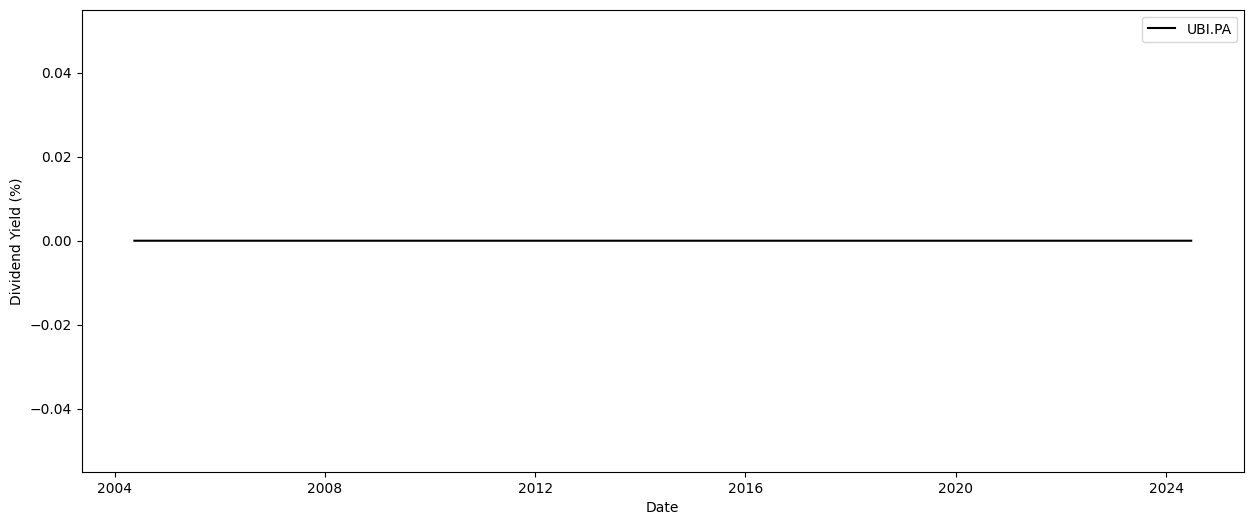

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.446866
share_price      1.000000
Name: share_price, dtype: float64


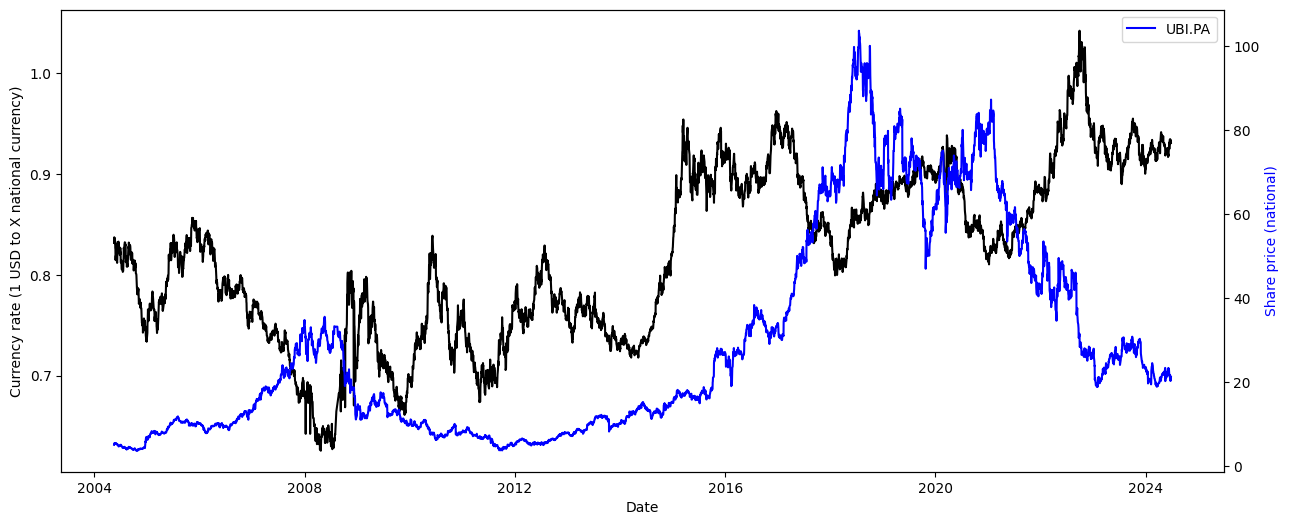

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

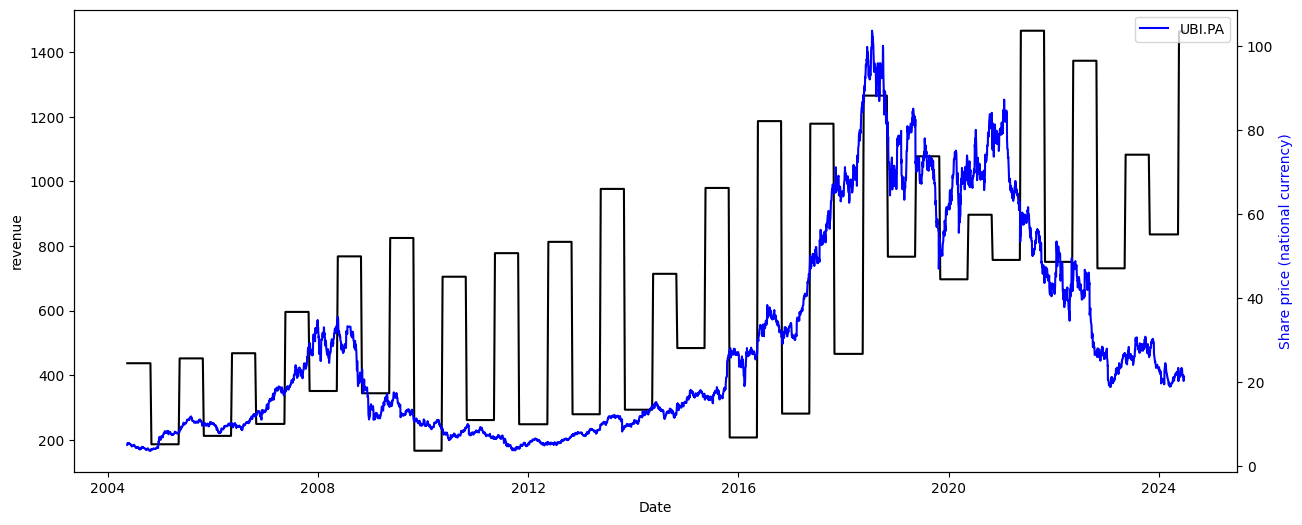

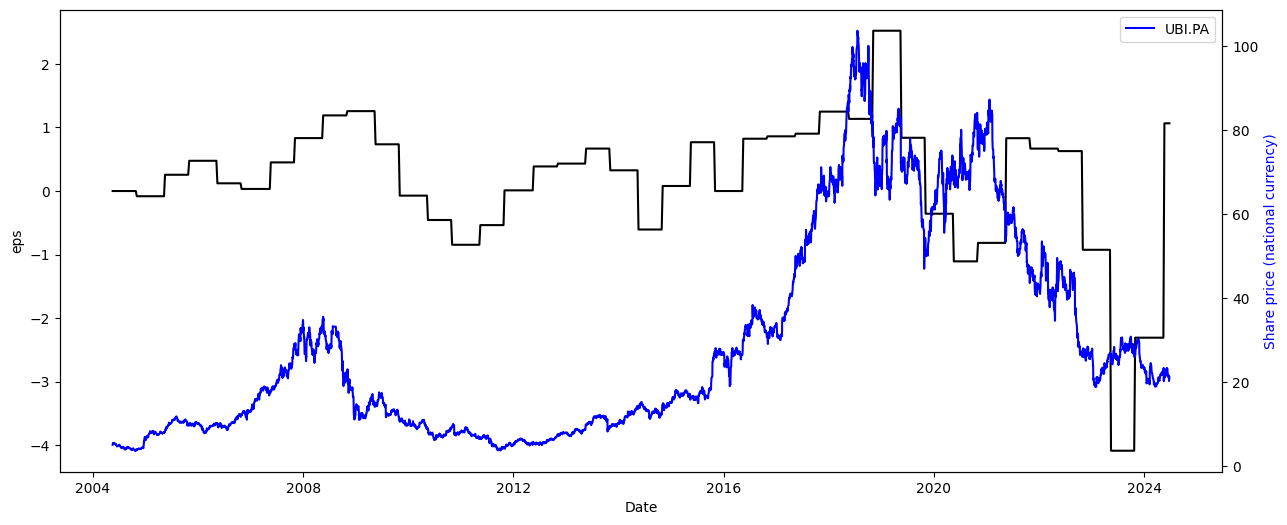

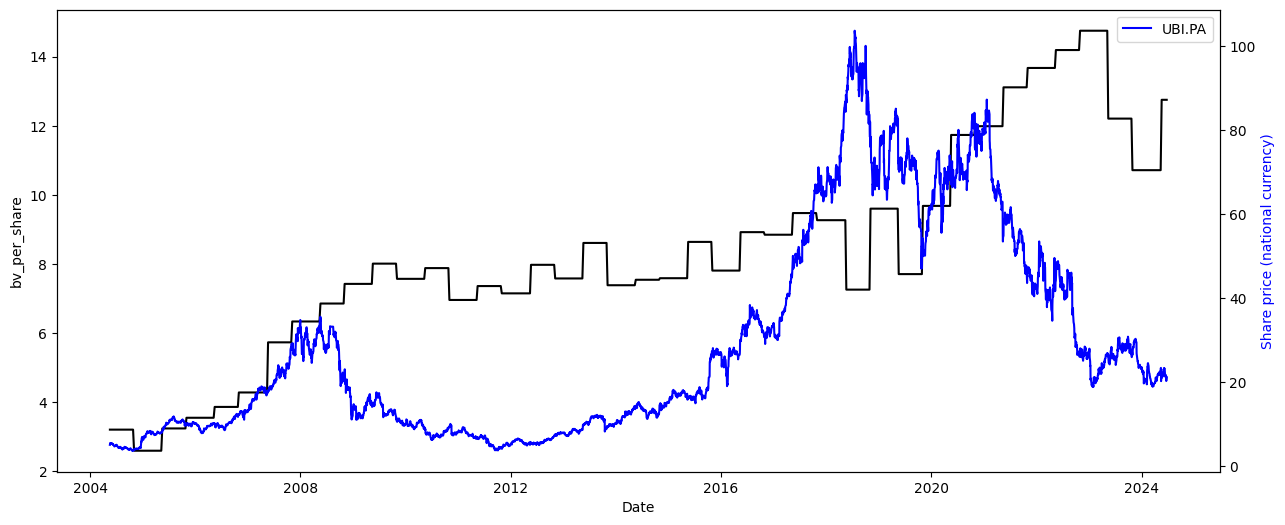

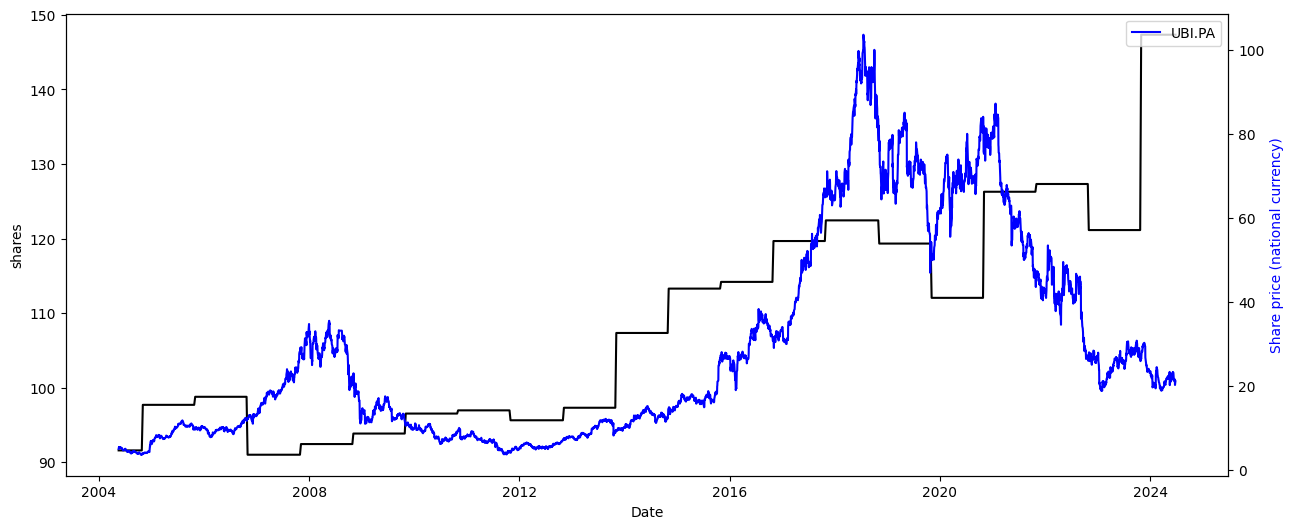

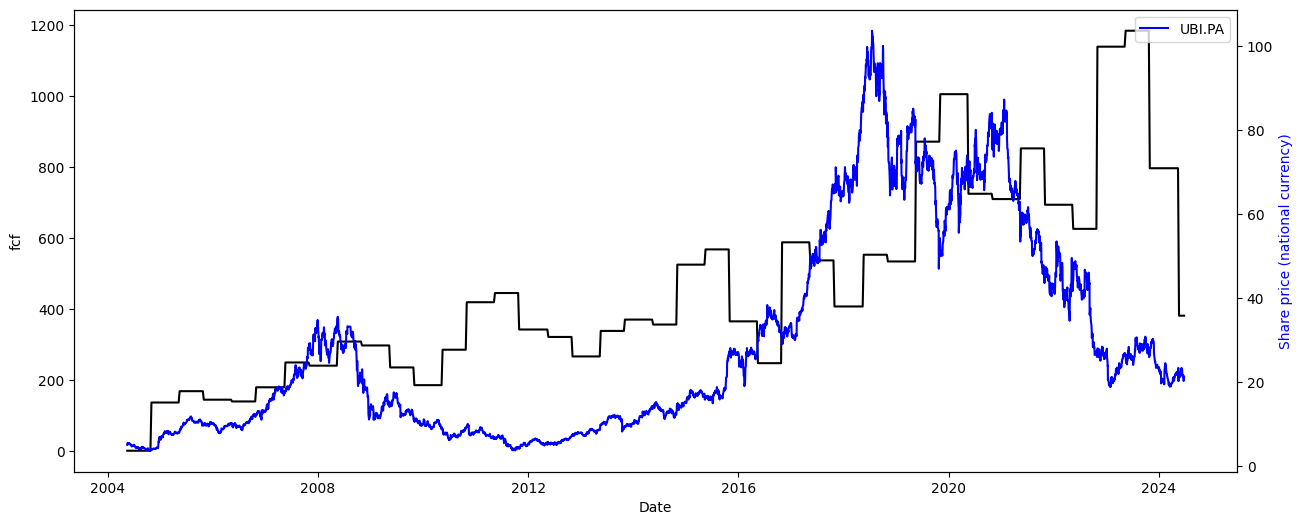

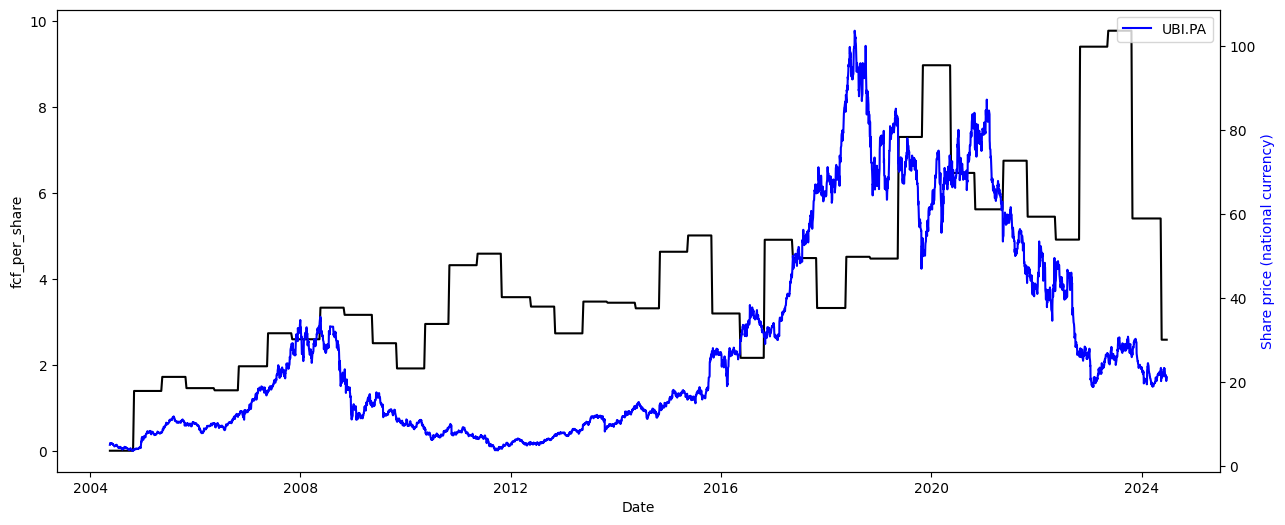

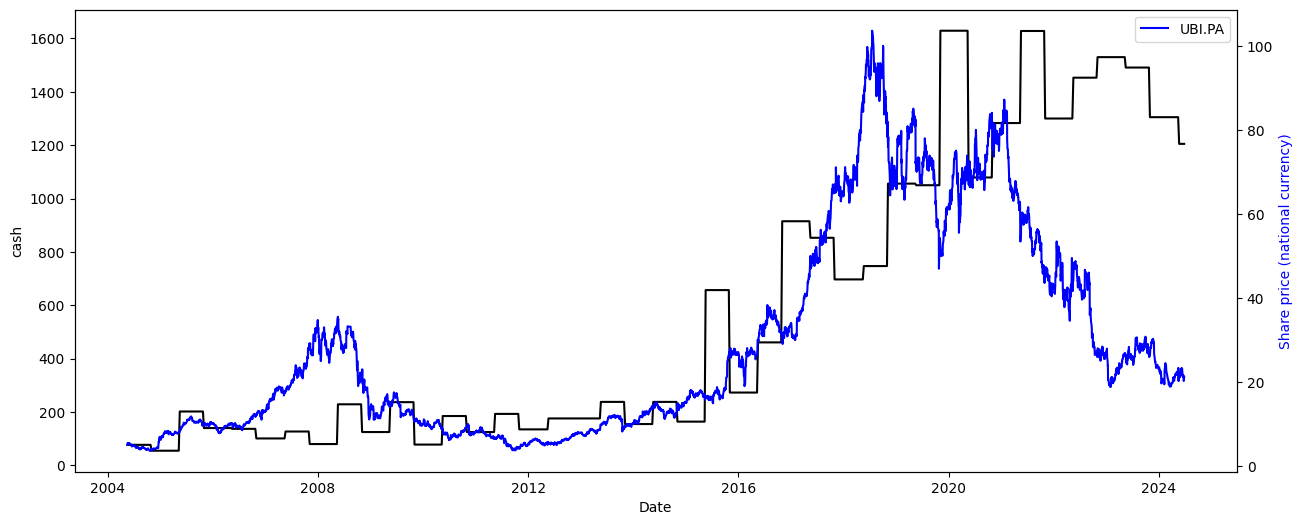

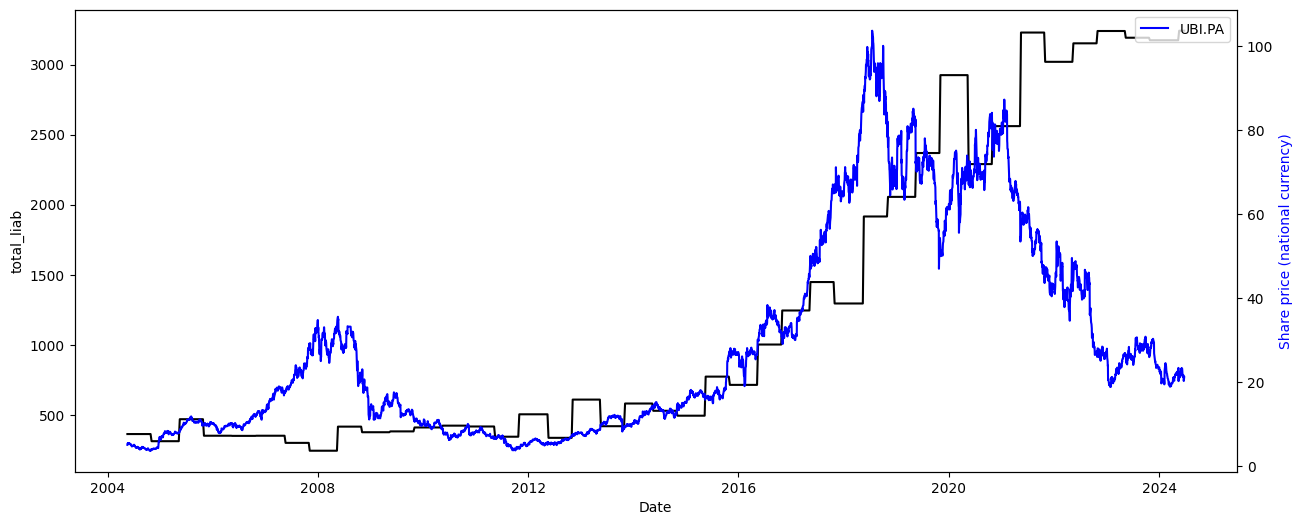

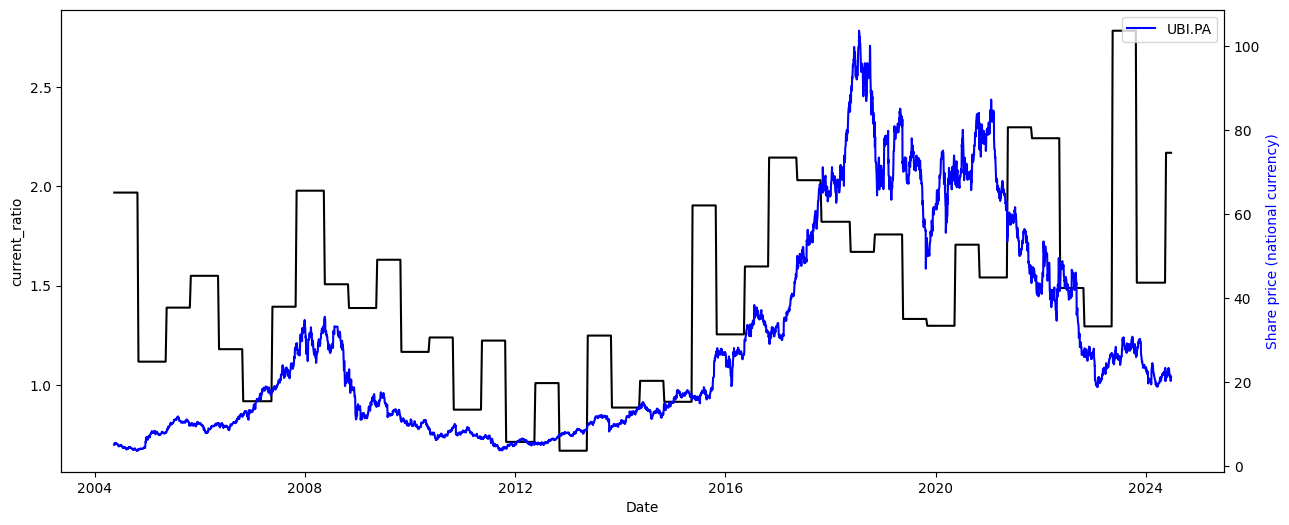

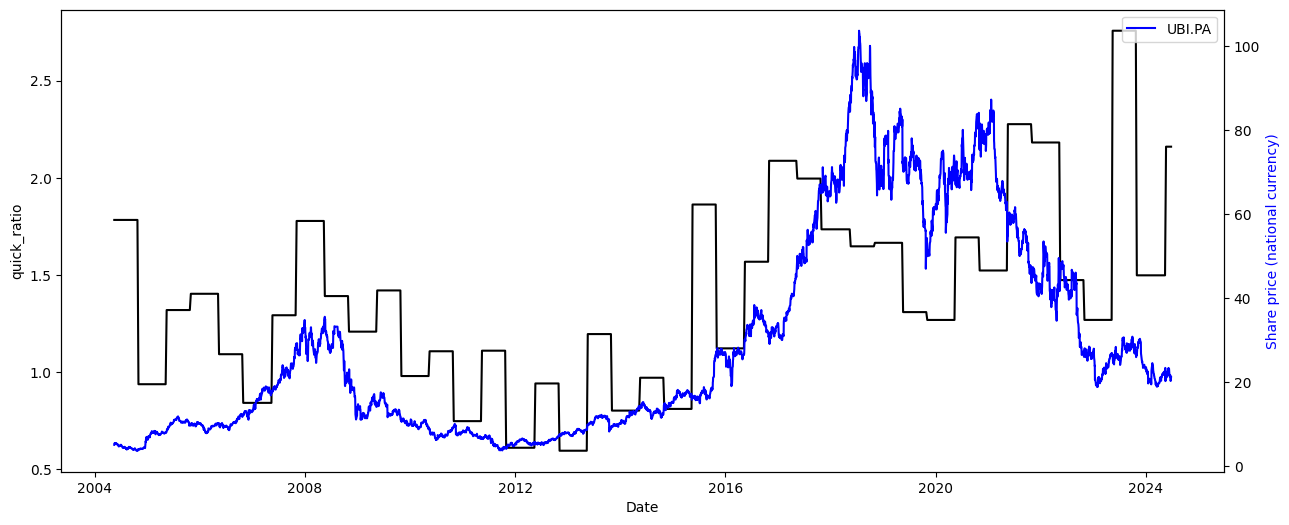

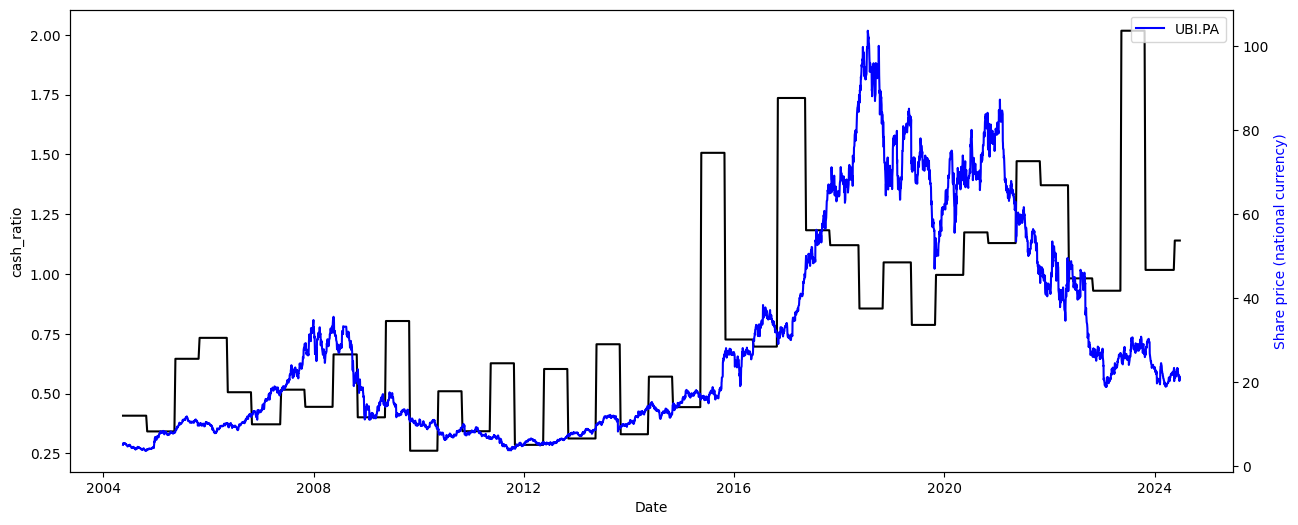

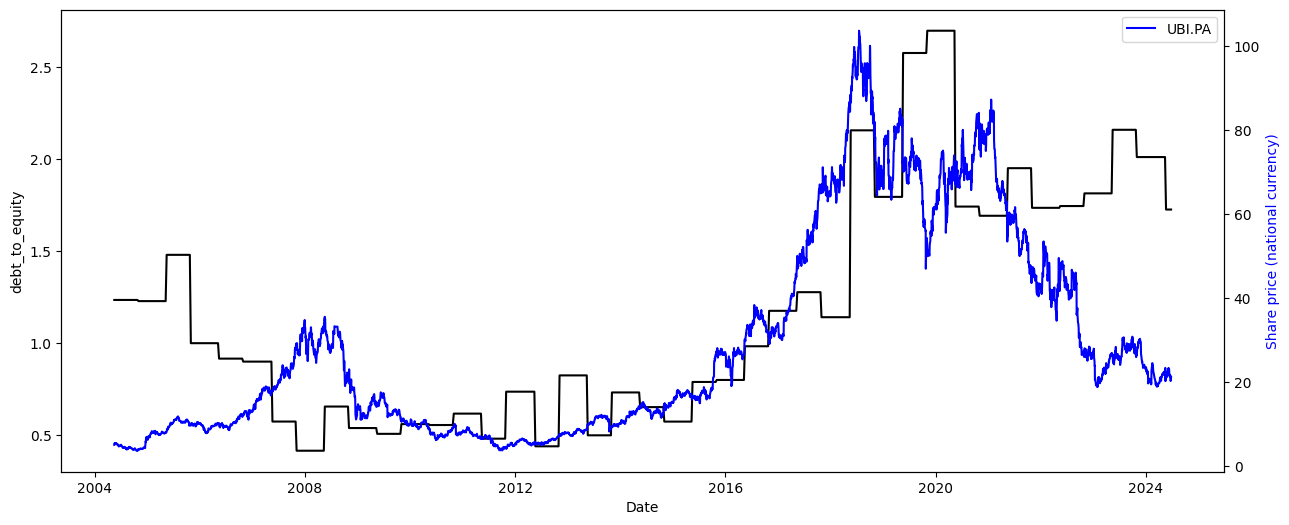

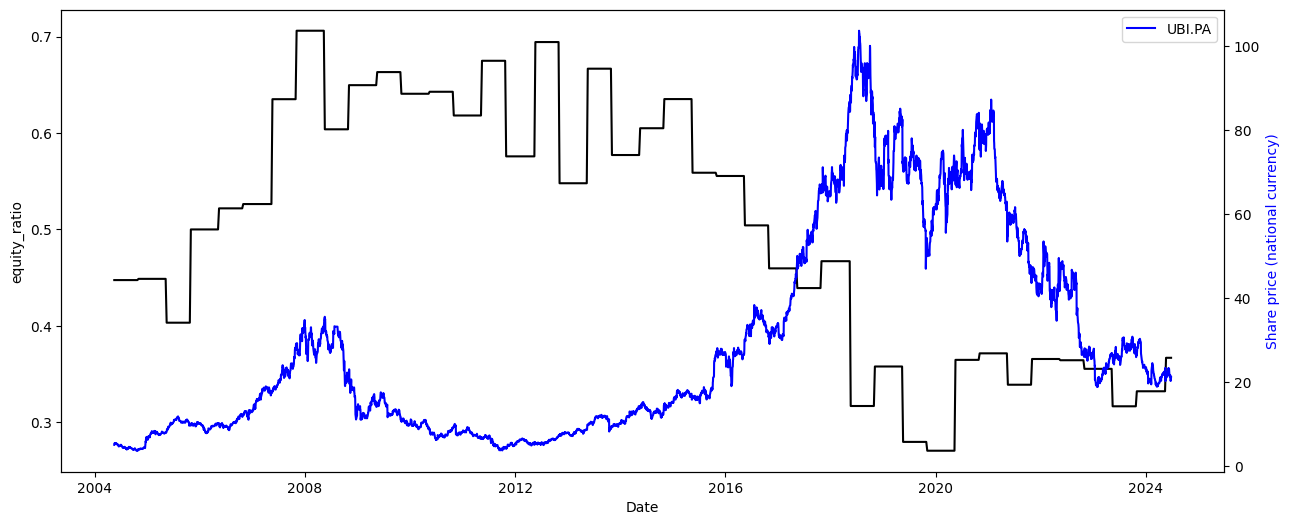

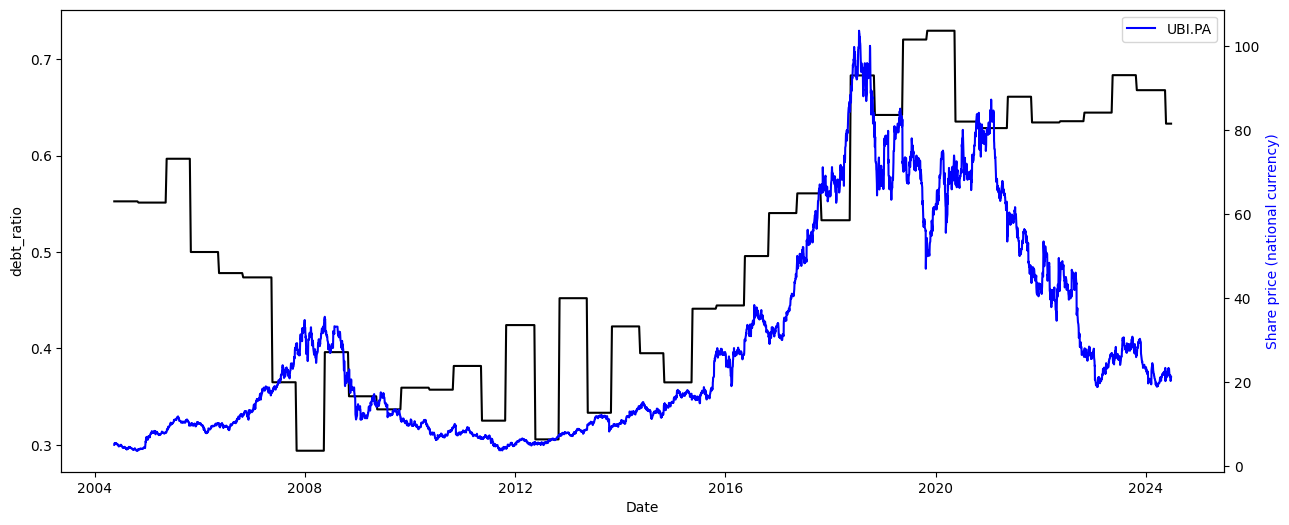

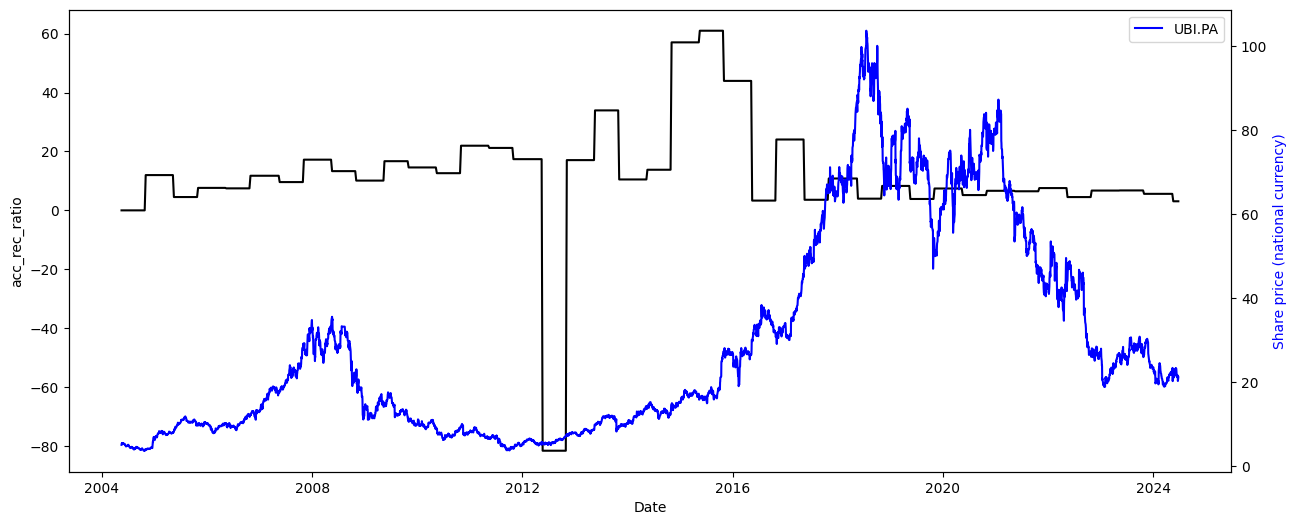

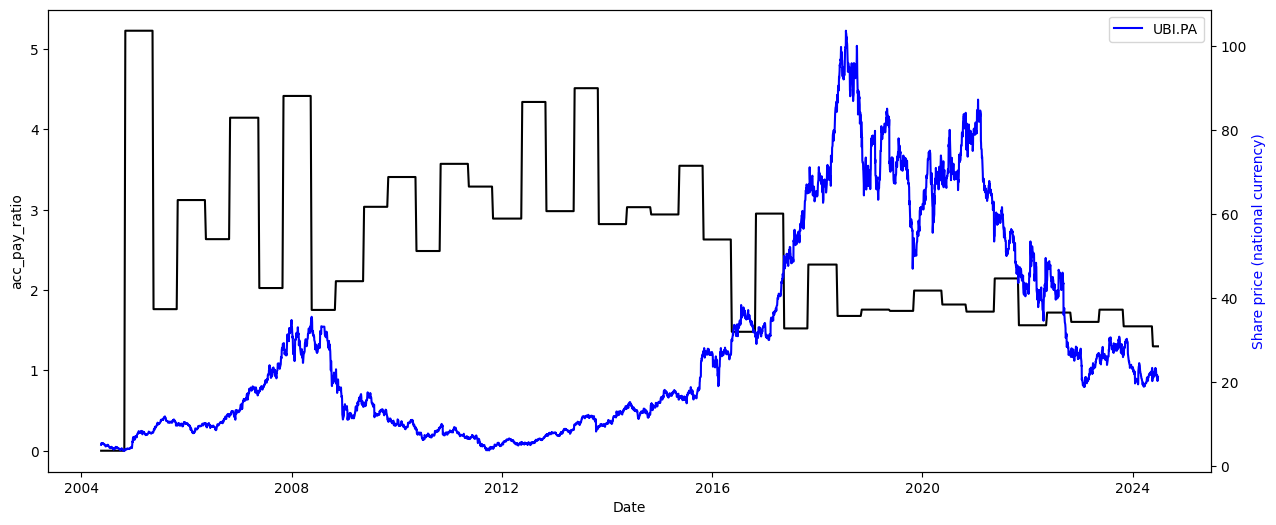

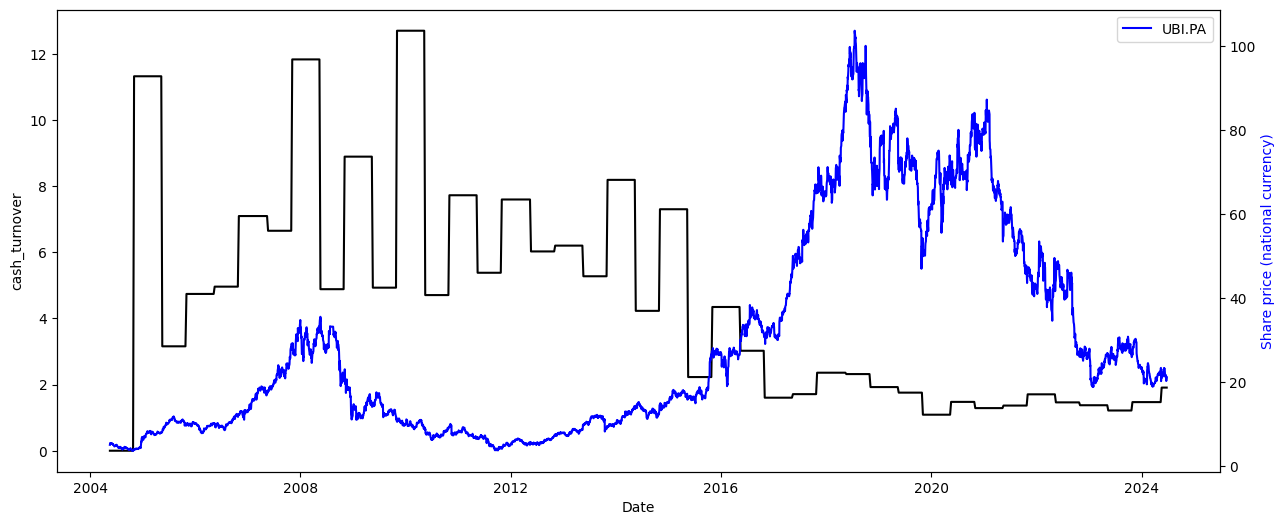

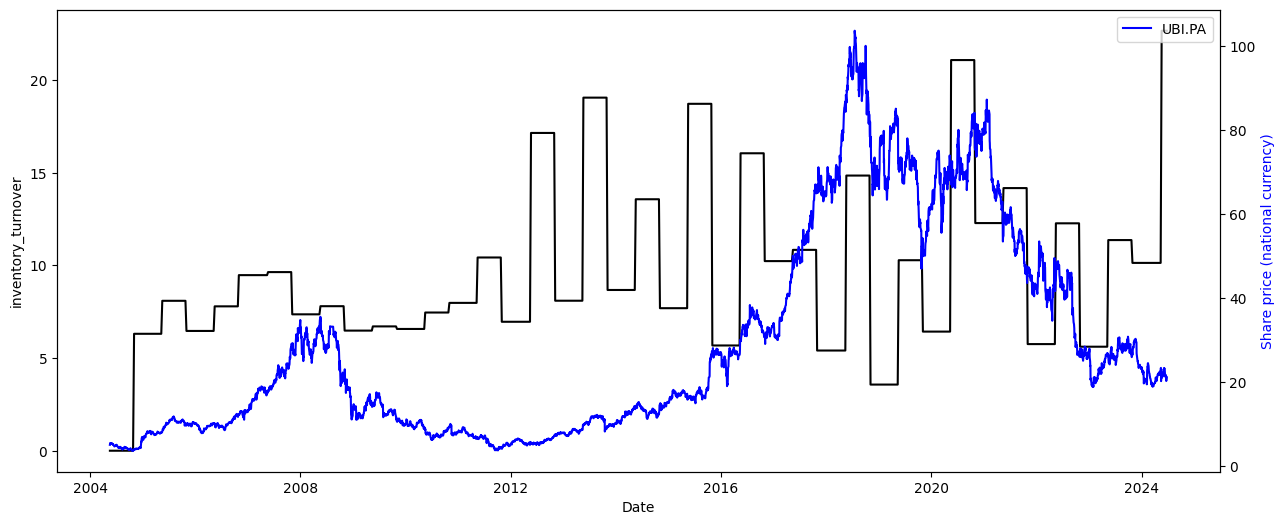

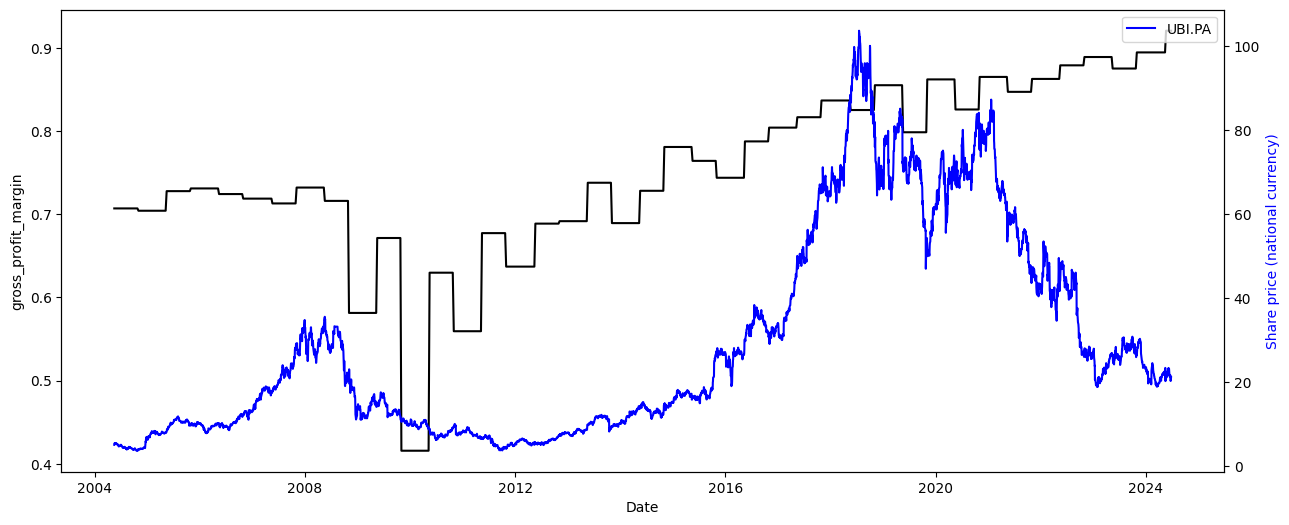

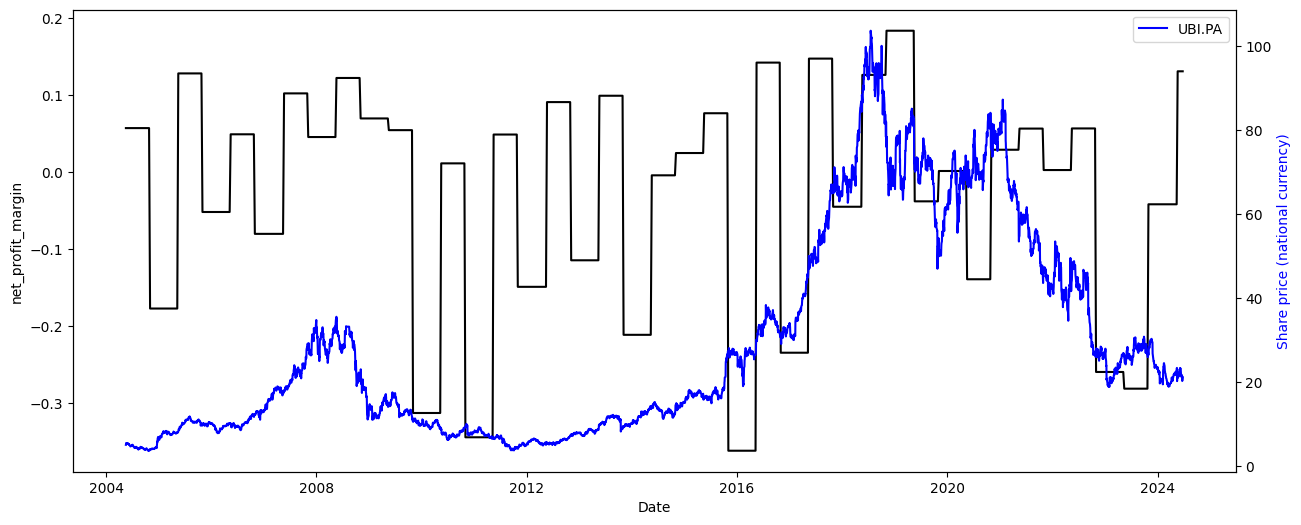

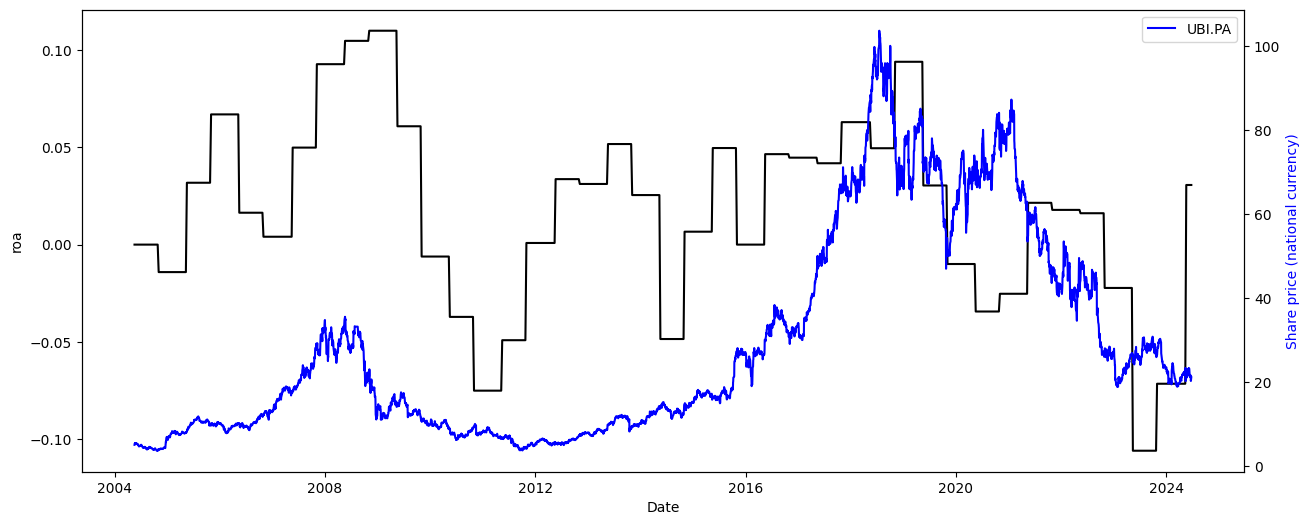

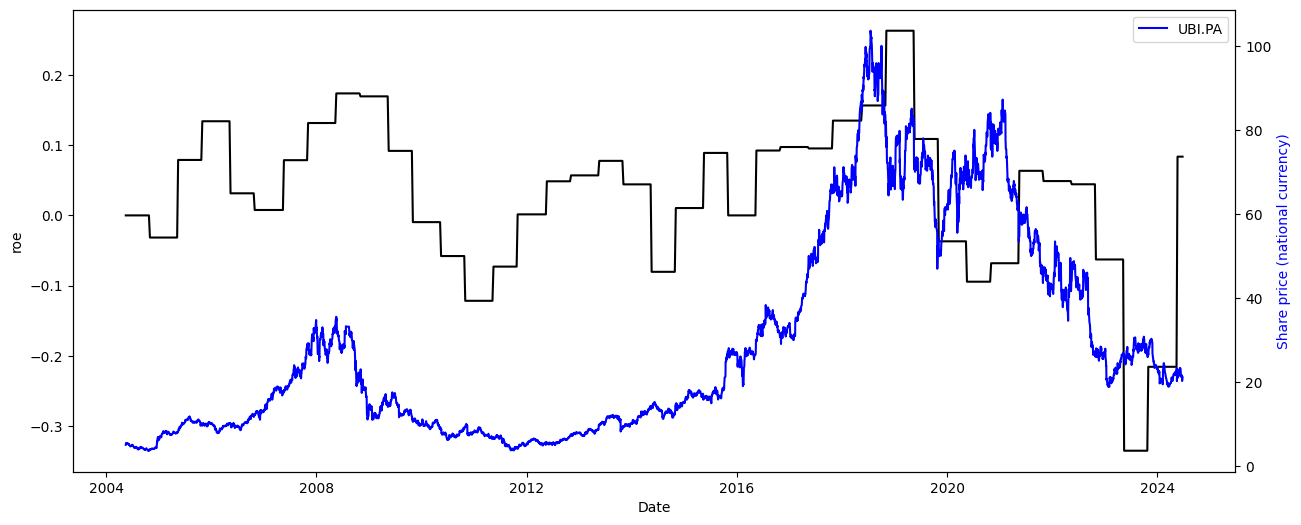

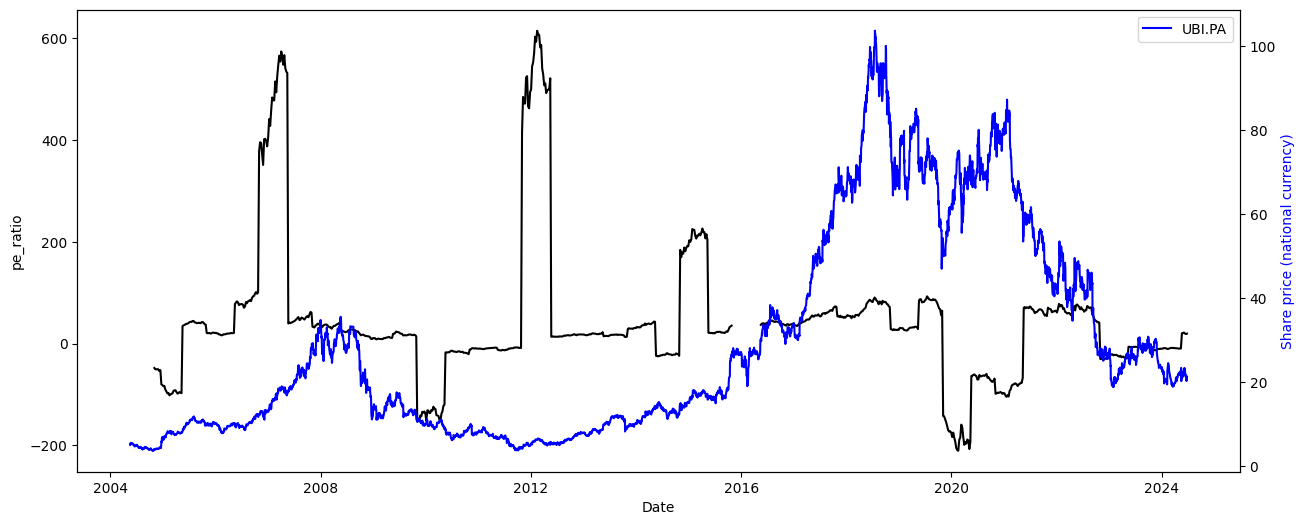

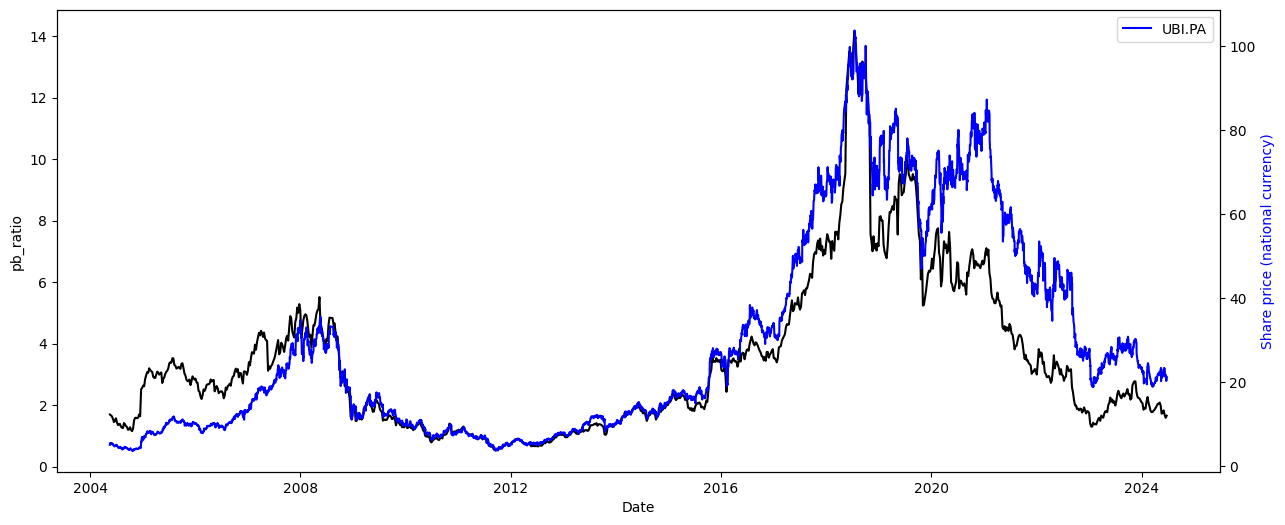

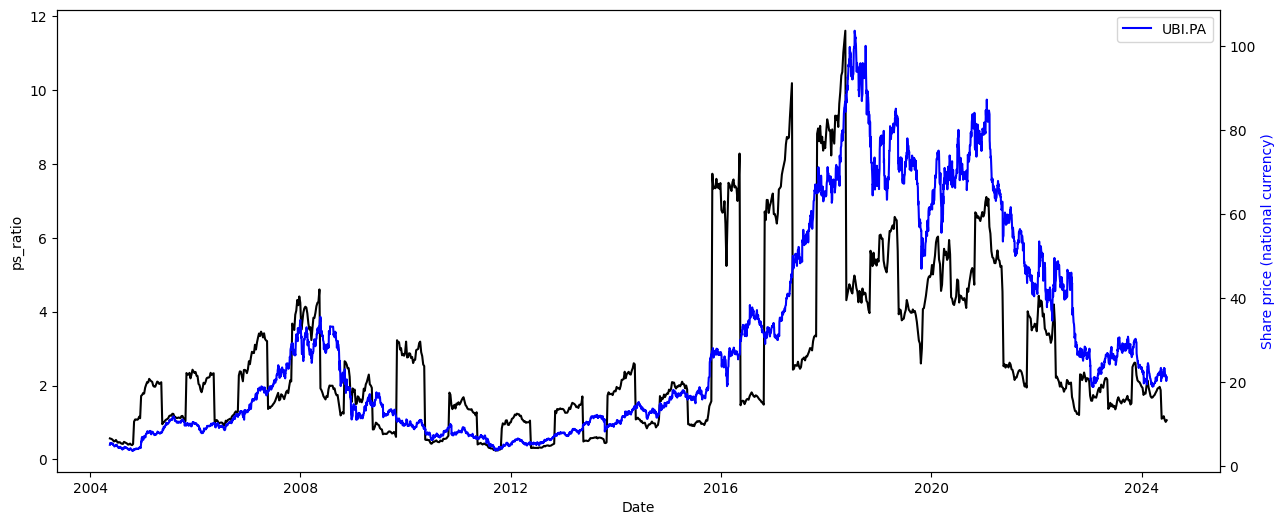

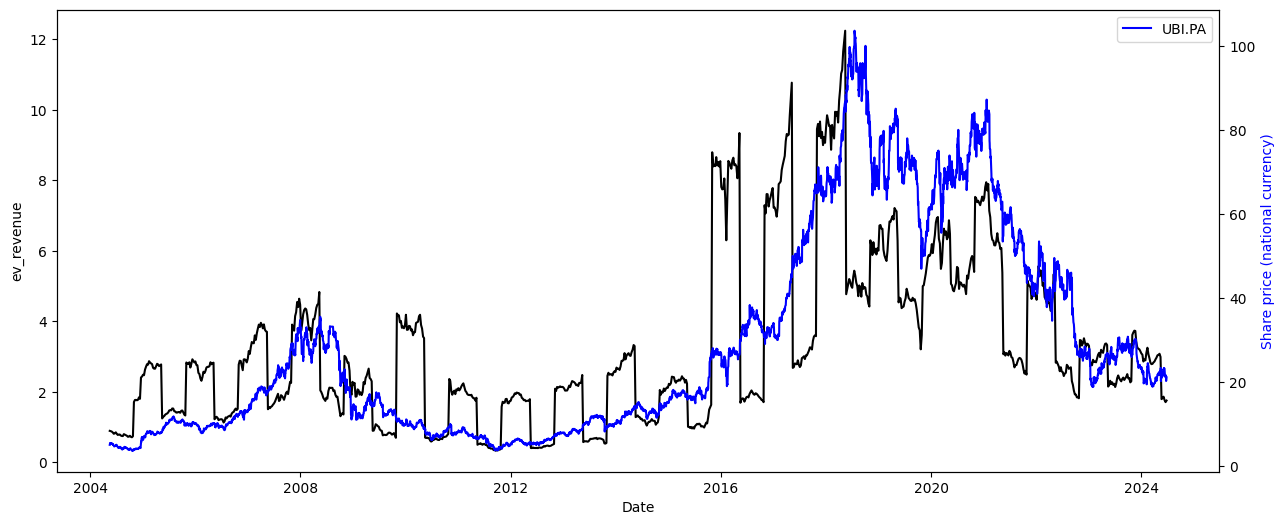

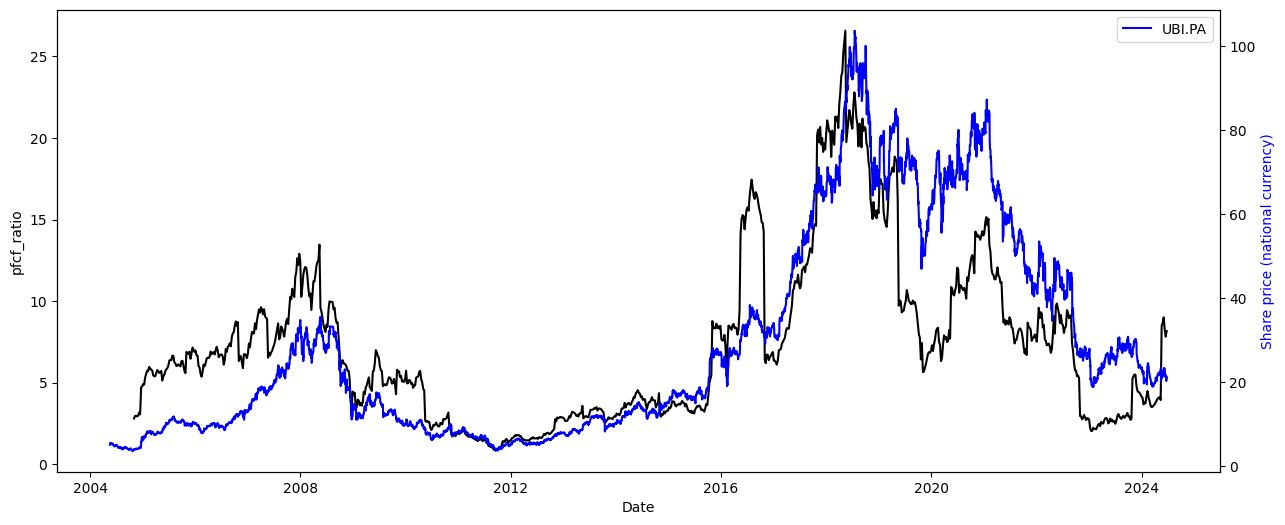

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

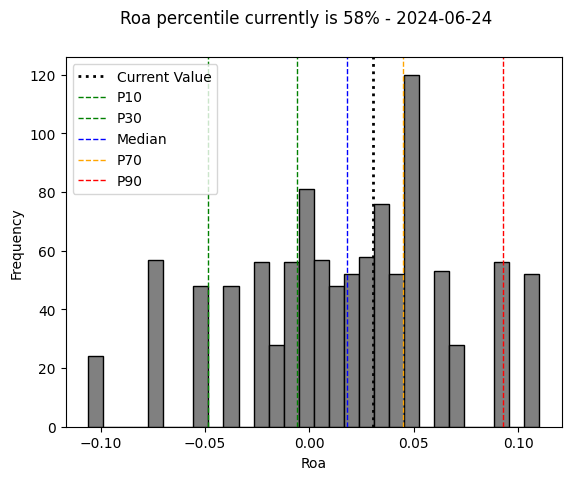

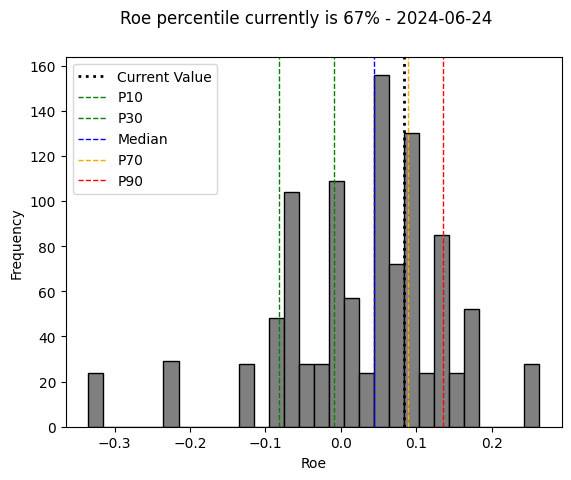

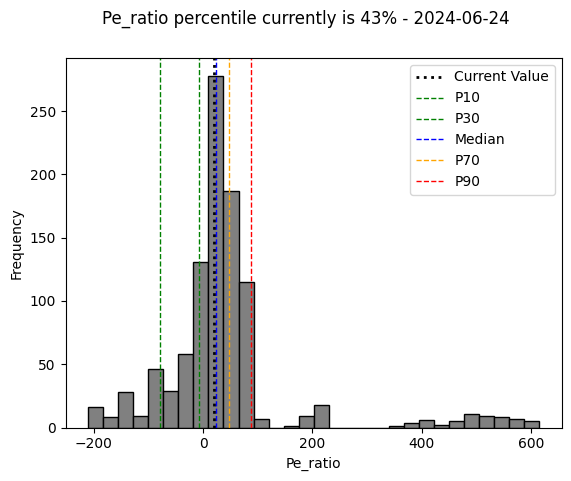

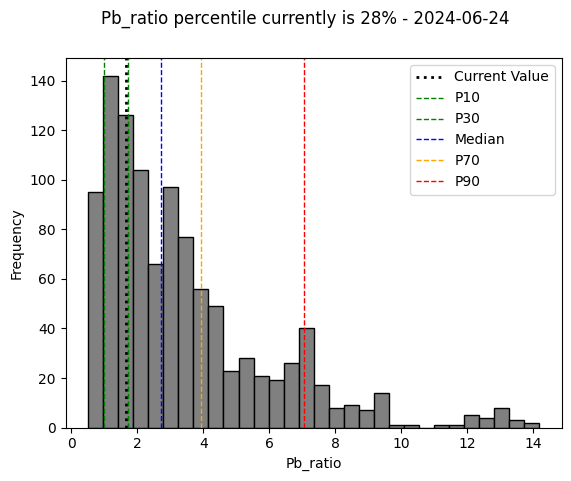

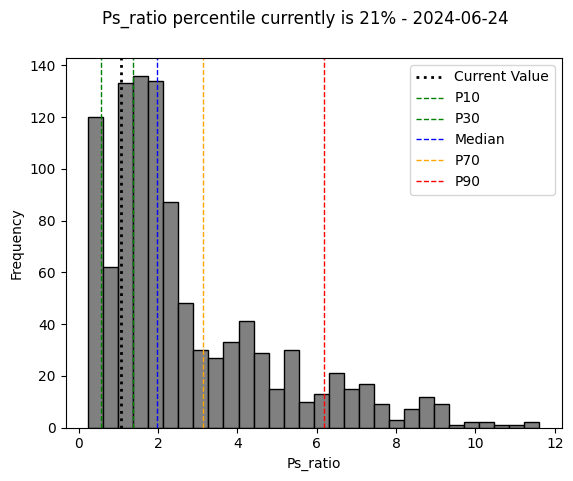

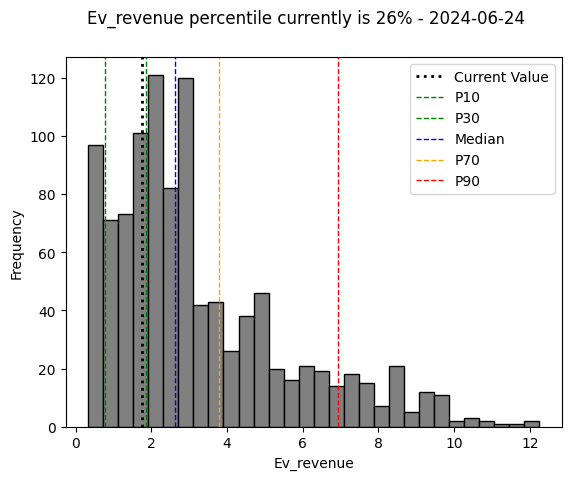

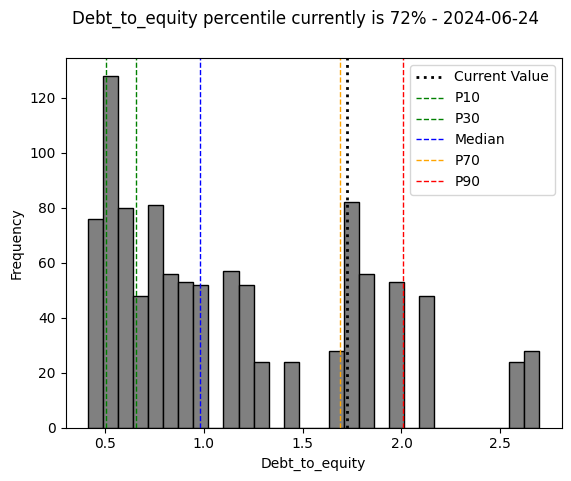

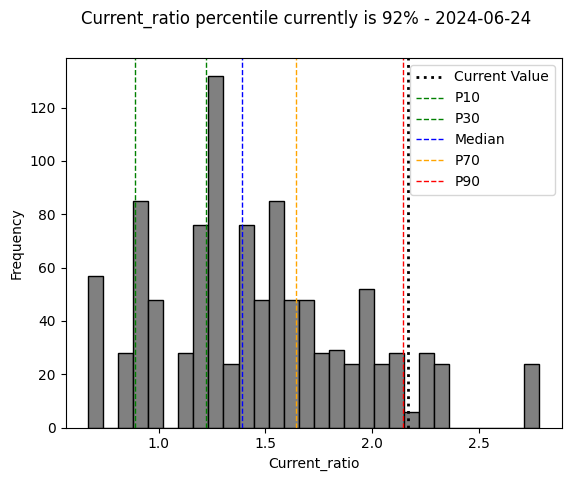

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.953581,0.120975,0.296365,0.185414,0.119434,-0.236943,0.126701
roe,0.953581,1.000000,0.149205,0.373341,0.225719,0.159830,-0.187114,0.051214
pe_ratio,0.120975,0.149205,1.000000,-0.059120,-0.109665,-0.119345,-0.201253,-0.236773
pb_ratio,0.296365,0.373341,-0.059120,1.000000,0.670366,0.637958,0.581349,0.338701
ps_ratio,0.185414,0.225719,-0.109665,0.670366,1.000000,0.992141,0.343704,0.299783
ev_revenue,0.119434,0.159830,-0.119345,0.637958,0.992141,1.000000,0.395038,0.282214
debt_to_equity,-0.236943,-0.187114,-0.201253,0.581349,0.343704,0.395038,1.000000,0.419876
current_ratio,0.126701,0.051214,-0.236773,0.338701,0.299783,0.282214,0.419876,1.000000


6 timestemos have been found!


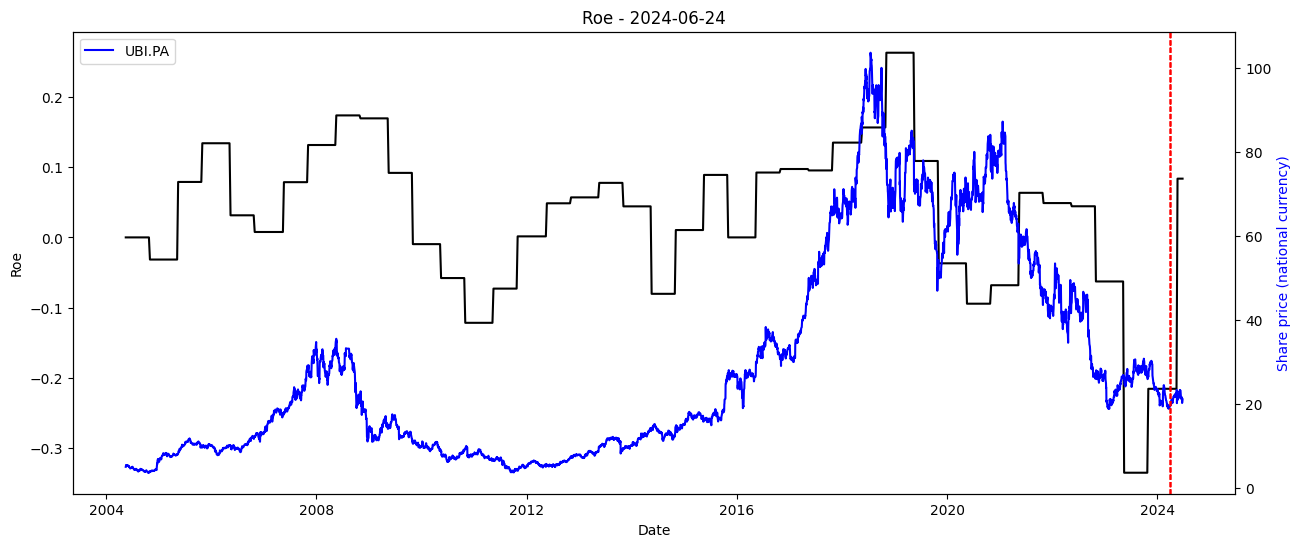

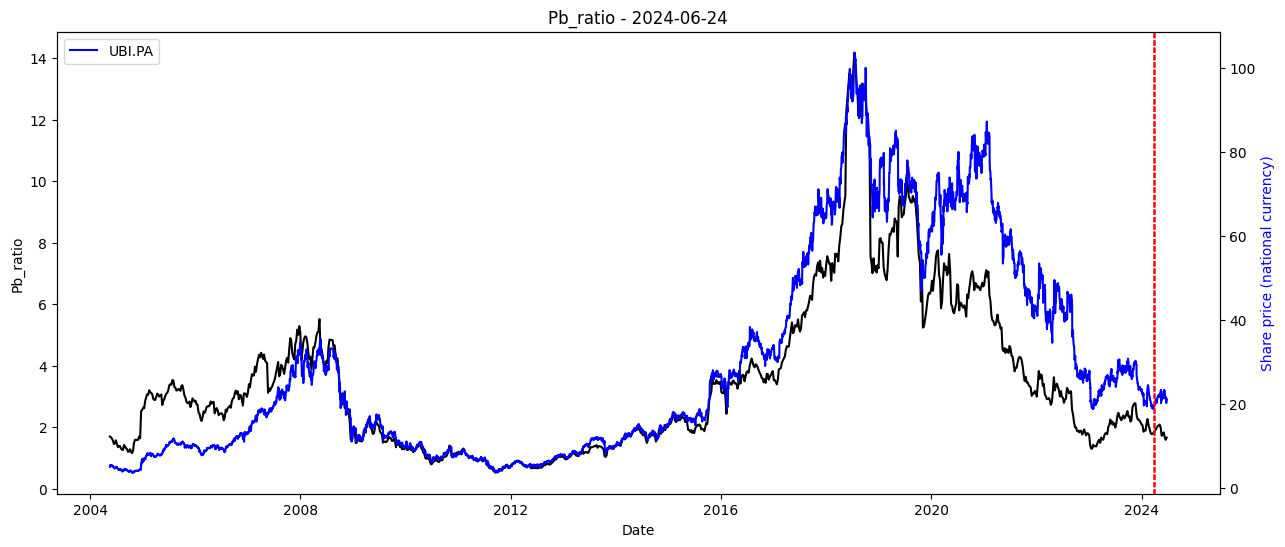

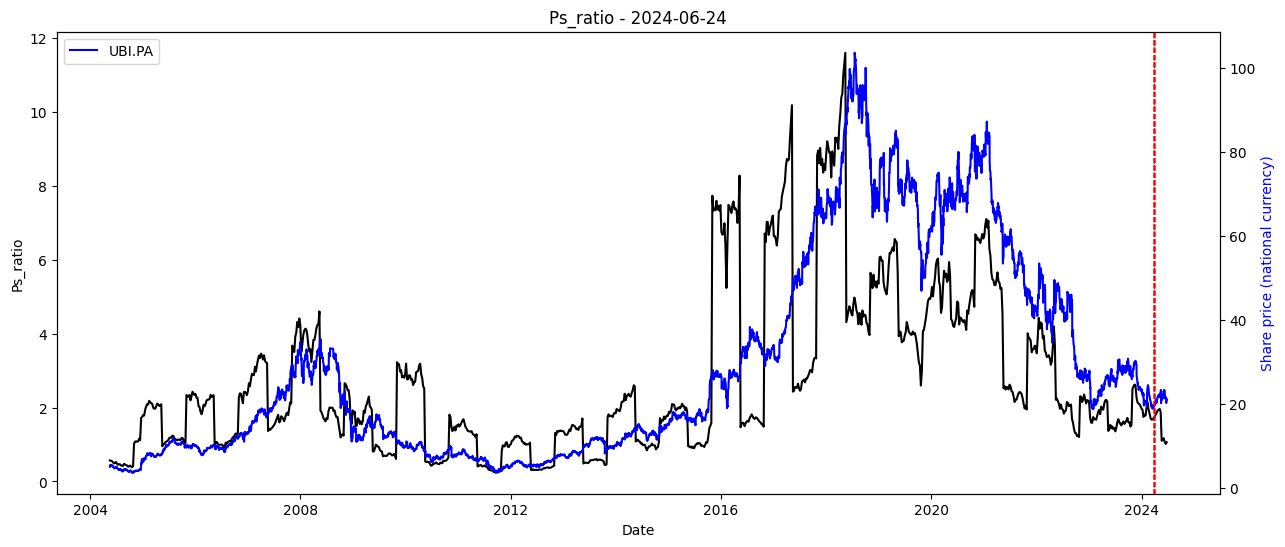

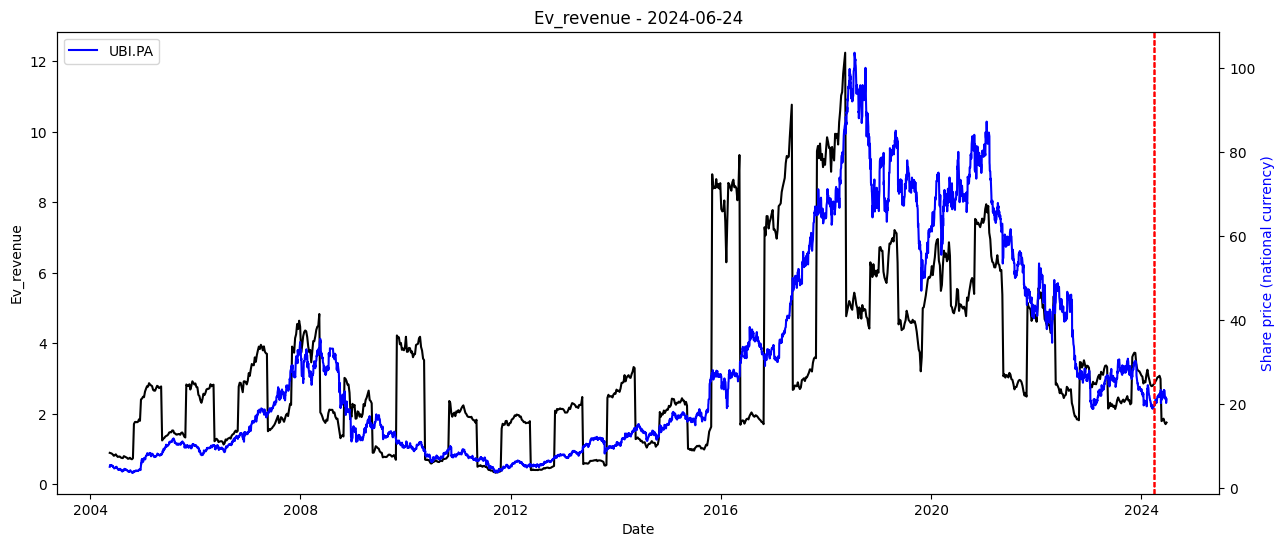

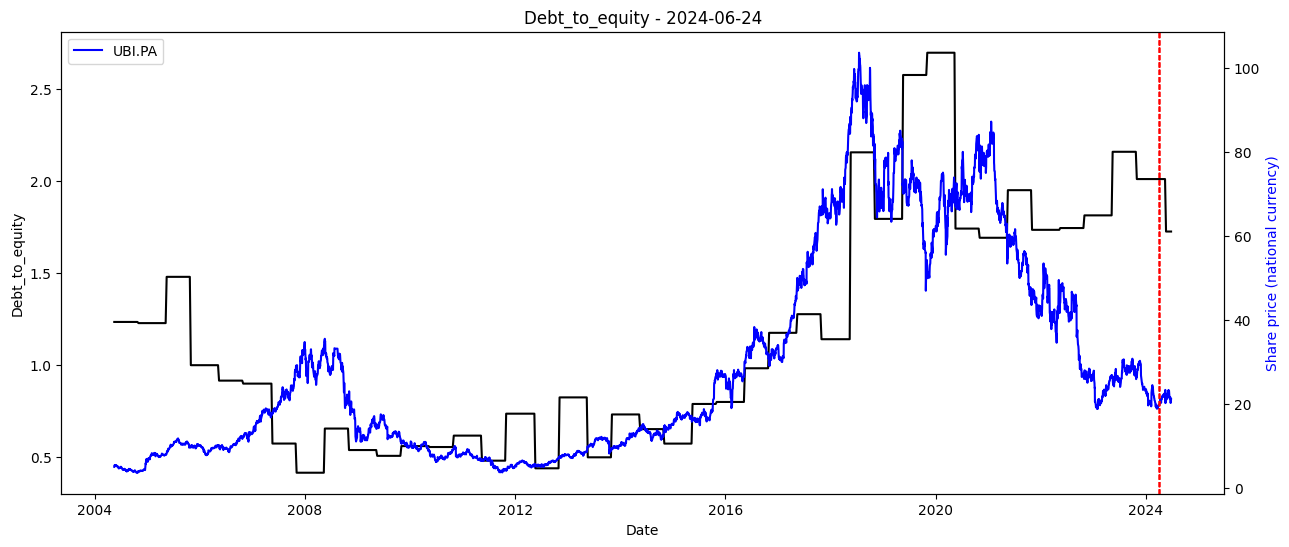

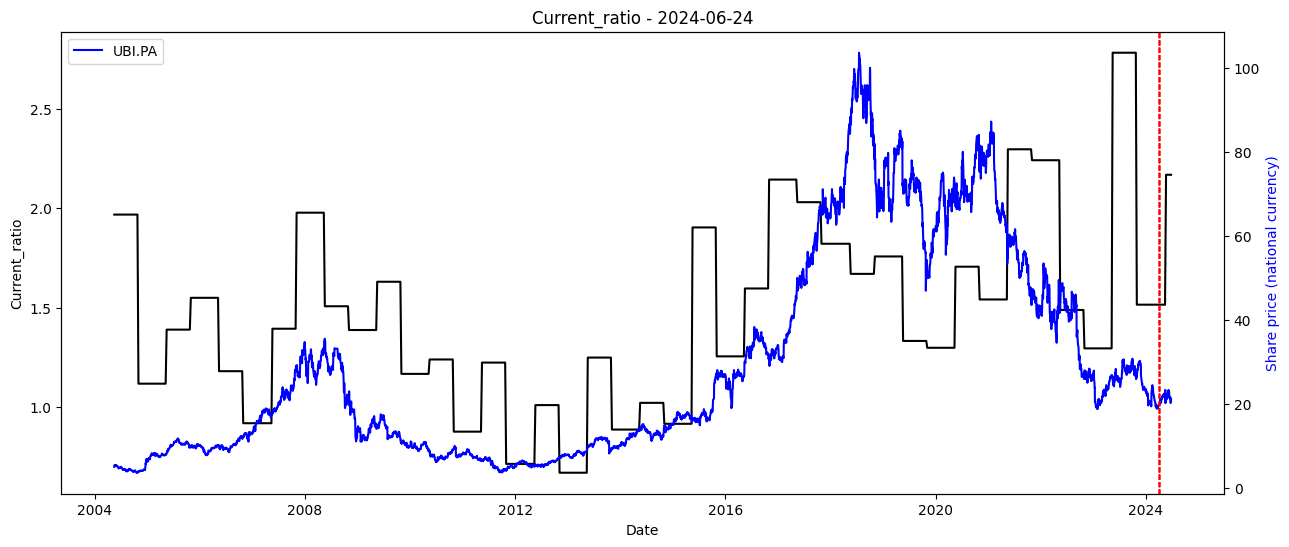

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )